## 1. Perkenalan

====================================================


Program ini dibuat untuk membuat model yang bisa memprediksi terkait apakah seseorang gagal bayar atau tidak berdasarkan data credit card. Akan dilakukan analisa data sebelum menggunakan model seperti Logistic Regression, KNN dan SVM untuk melakukan prediksi.

====================================================

## 2. Query SQL

Dibawah ini merupakan query yang dijalankan untuk mengambil data dari BigQuery.

```SQL
SELECT    
      limit_balance,   
      CAST(sex AS INT) AS sex,  
      CAST(education_level AS INT) AS education_level,  
      CAST(marital_status AS INT) AS marital_status,   
      age,  
      pay_0,  
      pay_2,  
      pay_3,  
      pay_4,  
      CAST(pay_5 AS FLOAT64) AS pay_5,  
      CAST(pay_6 AS FLOAT64) AS pay_6,  
      bill_amt_1,  
      bill_amt_2,  
      bill_amt_3,  
      bill_amt_4,  
      bill_amt_5,  
      bill_amt_6,  
      pay_amt_1,   
      pay_amt_2,   
      pay_amt_3,   
      pay_amt_4,   
      pay_amt_5,   
      pay_amt_6,   
      CAST(default_payment_next_month AS INT) AS default_payment_next_month  
FROM `bigquery-public-data.ml_datasets.credit_card_default`  
LIMIT 23988;
```  

## 3. Import Libraries

In [3]:
# Melakukan import libraries
import pandas as pd
import numpy as np
import pickle
import json
from scipy import stats
from scipy.stats import kendalltau
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.preprocessing import StandardScaler
from feature_engine.outliers import Winsorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score, precision_score, recall_score

## 4. Data Loading

In [4]:
# Meload data dari csv ke dataframe
df = pd.read_csv("P1G5_Set_1_panji_putra.csv")
pd.set_option('display.max_columns', None)
print(df.info())

# Menampilkan data 10 pertama dan terakhir
display(df.head(10))
display(df.tail(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2965 entries, 0 to 2964
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   limit_balance               2965 non-null   float64
 1   sex                         2965 non-null   int64  
 2   education_level             2965 non-null   int64  
 3   marital_status              2965 non-null   int64  
 4   age                         2965 non-null   float64
 5   pay_0                       2965 non-null   float64
 6   pay_2                       2965 non-null   float64
 7   pay_3                       2965 non-null   float64
 8   pay_4                       2965 non-null   float64
 9   pay_5                       2965 non-null   float64
 10  pay_6                       2965 non-null   float64
 11  bill_amt_1                  2965 non-null   float64
 12  bill_amt_2                  2965 non-null   float64
 13  bill_amt_3                  2965 

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
0,80000.0,1,6,1,54.0,0.0,0.0,0.0,0.0,0.0,0.0,61454.0,61808.0,62290.0,29296.0,26210.0,17643.0,2545.0,2208.0,1336.0,2232.0,542.0,348.0,1
1,200000.0,1,4,1,49.0,0.0,0.0,0.0,0.0,0.0,0.0,49221.0,49599.0,50942.0,50146.0,50235.0,48984.0,1689.0,2164.0,2500.0,3480.0,2500.0,3000.0,0
2,20000.0,2,6,2,22.0,0.0,0.0,0.0,0.0,0.0,0.0,19568.0,19420.0,15535.0,1434.0,500.0,0.0,4641.0,1019.0,900.0,0.0,1500.0,0.0,1
3,260000.0,2,4,2,33.0,0.0,0.0,0.0,0.0,0.0,0.0,18457.0,22815.0,27086.0,27821.0,30767.0,29890.0,5000.0,5000.0,1137.0,5000.0,1085.0,5000.0,0
4,150000.0,1,4,2,32.0,0.0,0.0,0.0,-1.0,0.0,0.0,159919.0,68686.0,161192.0,150464.0,143375.0,146411.0,4019.0,146896.0,157436.0,4600.0,4709.0,5600.0,0
5,300000.0,2,4,2,32.0,0.0,0.0,0.0,0.0,0.0,-1.0,54053.0,65235.0,64747.0,65150.0,-450.0,700.0,15235.0,1491.0,1303.0,0.0,2000.0,1400.0,0
6,130000.0,1,1,1,45.0,0.0,0.0,0.0,0.0,0.0,0.0,58180.0,59134.0,61156.0,62377.0,63832.0,65099.0,2886.0,2908.0,2129.0,2354.0,2366.0,2291.0,0
7,200000.0,1,1,1,58.0,0.0,0.0,0.0,0.0,0.0,0.0,192461.0,195970.0,122214.0,124647.0,126921.0,129167.0,7822.0,4417.0,4446.0,4597.0,4677.0,4698.0,0
8,500000.0,1,1,1,39.0,0.0,0.0,0.0,0.0,0.0,0.0,133598.0,167378.0,171106.0,174500.0,137406.0,204975.0,54209.0,4607.0,4603.0,5224.0,207440.0,7509.0,0
9,230000.0,1,1,1,48.0,0.0,0.0,0.0,0.0,0.0,0.0,160879.0,161797.0,165107.0,105508.0,108101.0,110094.0,7000.0,6607.0,3773.0,4290.0,4164.0,2000.0,0


,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
2955,360000.0,2,2,2,26.0,-1.0,-1.0,-1.0,-1.0,-2.0,-2.0,1968.0,459.0,2500.0,0.0,0.0,0.0,463.0,2500.0,0.0,0.0,0.0,0.0,0
2956,100000.0,1,3,1,40.0,0.0,0.0,-1.0,-1.0,-2.0,-2.0,12878.0,7702.0,2377.0,0.0,0.0,0.0,2000.0,2377.0,40000.0,0.0,0.0,0.0,0
2957,30000.0,2,3,1,48.0,1.0,-1.0,-1.0,-2.0,-2.0,-2.0,-100.0,100.0,0.0,0.0,0.0,0.0,200.0,0.0,0.0,0.0,0.0,0.0,0
2958,80000.0,2,3,1,39.0,-1.0,-1.0,-1.0,-1.0,-2.0,-1.0,5280.0,5000.0,5000.0,0.0,0.0,5000.0,5000.0,5000.0,0.0,5000.0,5000.0,470.0,0
2959,20000.0,1,3,2,26.0,-1.0,-1.0,-1.0,-2.0,-2.0,-2.0,96.0,780.0,0.0,0.0,0.0,0.0,1560.0,0.0,0.0,0.0,0.0,0.0,0
2960,80000.0,2,3,2,28.0,-1.0,-1.0,-1.0,-2.0,-2.0,-2.0,4280.0,2800.0,0.0,0.0,0.0,0.0,2800.0,0.0,0.0,0.0,0.0,0.0,0
2961,50000.0,2,3,1,51.0,-1.0,-1.0,-1.0,-1.0,-2.0,-2.0,752.0,300.0,5880.0,0.0,0.0,0.0,300.0,5880.0,0.0,0.0,0.0,0.0,1
2962,450000.0,2,2,1,38.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,390.0,390.0,390.0,390.0,390.0,390.0,390.0,780.0,390.0,390.0,390.0,390.0,1
2963,50000.0,2,2,1,44.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,1473.0,390.0,390.0,390.0,390.0,0.0,390.0,390.0,390.0,390.0,0.0,780.0,0
2964,290000.0,2,2,1,39.0,1.0,-2.0,-2.0,-2.0,-2.0,-2.0,-70.0,9540.0,390.0,3184.0,390.0,390.0,10000.0,800.0,3184.0,390.0,390.0,6617.0,0


Dari hasil diatas kita bisa melihat bahwa terdapat 2965 rows dan 24 kolom pada data. Kita juga sudah berhasil mengubah data type dari kolom 'sex', 'education_level', 'marital_status' dan 'default_payment_next_month' yang tadinya STRING menjadi INT. Lalu, kolom pay_5 dan pay_6 dari STRING menjadi FLOAT

In [5]:
# Melakukan pencarian null value
df.isnull().sum()

limit_balance                 0
sex                           0
education_level               0
marital_status                0
age                           0
pay_0                         0
pay_2                         0
pay_3                         0
pay_4                         0
pay_5                         0
pay_6                         0
bill_amt_1                    0
bill_amt_2                    0
bill_amt_3                    0
bill_amt_4                    0
bill_amt_5                    0
bill_amt_6                    0
pay_amt_1                     0
pay_amt_2                     0
pay_amt_3                     0
pay_amt_4                     0
pay_amt_5                     0
pay_amt_6                     0
default_payment_next_month    0
dtype: int64

Dari hasil diatas kita bisa melihat bahwa tidak terdapat null pada data.

In [6]:
# Melakukan pencarian duplicate
df.duplicated().sum()

1

Terdapat 1 duplicate yang kita temukan dan akan kita lakukan drop.

In [7]:
# Melakukan drop pada duplicate
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

Setelah dilakukan drop sudah terlihat bahwa tidak terdapat duplicate lagi pada data.

## 5. Exploratory Data Analysis (EDA)

### Melihat distribusi data pada kolom 'age'

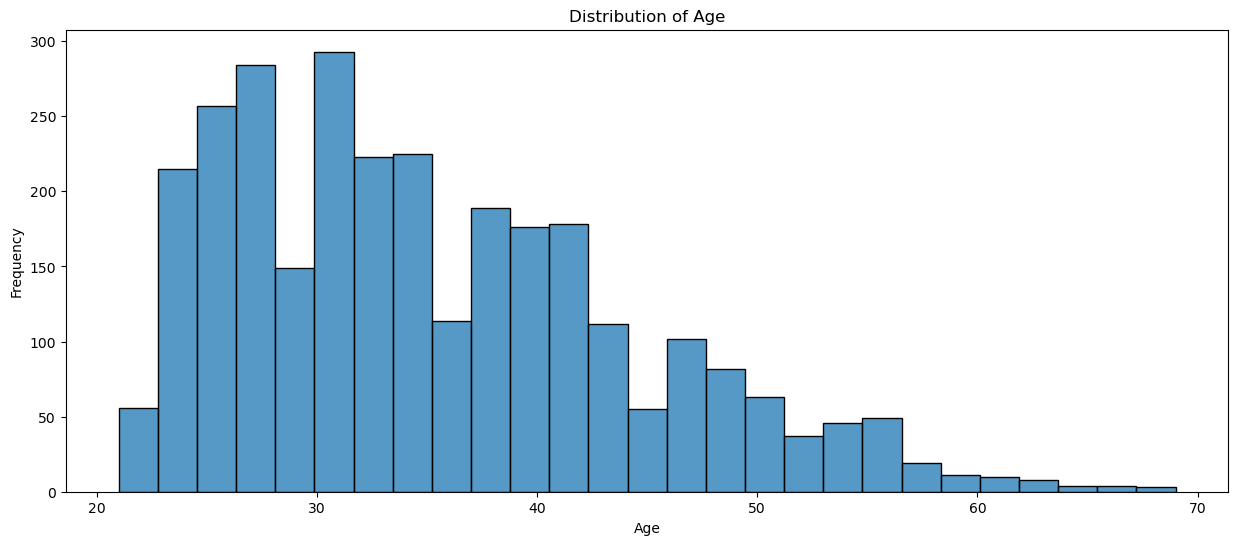

In [7]:
# Membuat histogram
plt.figure(figsize=(15, 6))
sns.histplot(df['age'])

plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')

plt.show()

Dapat dilihat bahwa distribusi data usia dalam gambar tersebut dapat diklasifikasikan sebagai normal distribution. Hal ini dapat dilihat dari bentuk histogram yang berbentuk simetris, yaitu titik tengah kurva berada di tengah-tengah dan simetris terhadap sumbu vertikal.

### Membuat Boxplot untuk melihat distribusi data pada kolom limit_balance

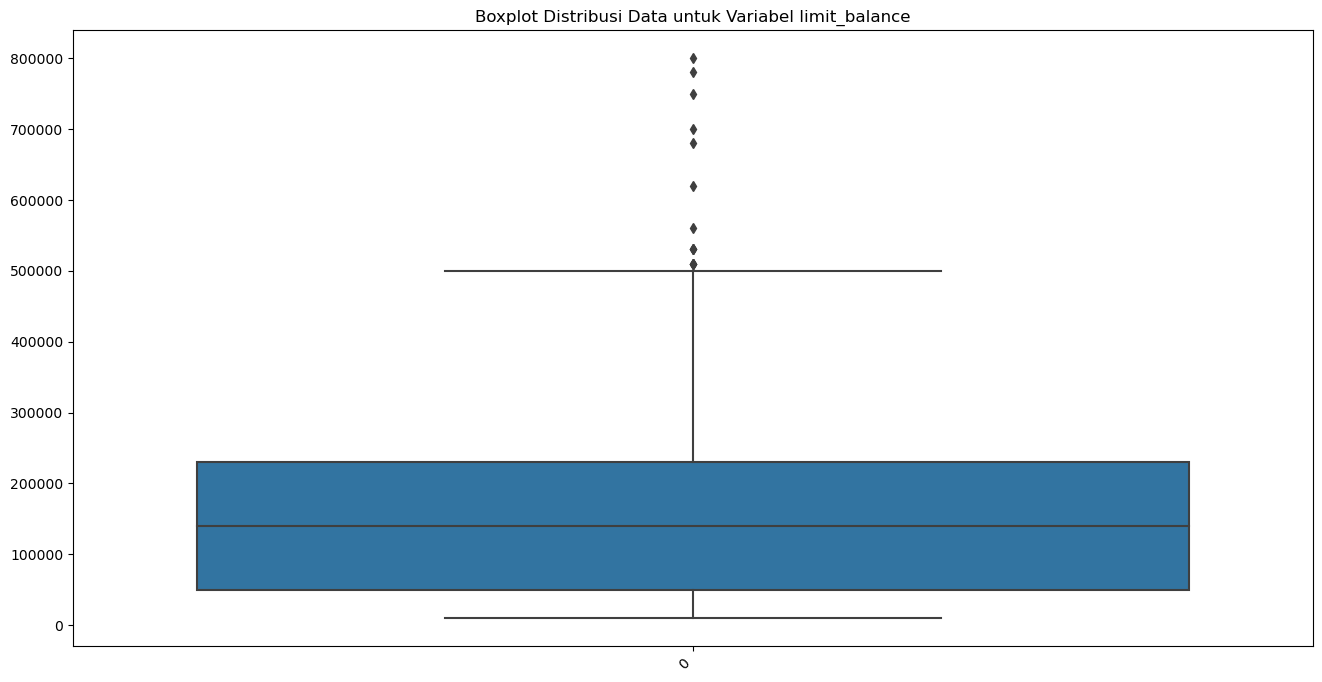

In [8]:
# Mengatur ukuran gambar
plt.figure(figsize=(16, 8))

# Membuat boxplot untuk setiap variabel numerik
sns.boxplot(data=df['limit_balance'])
plt.title('Boxplot Distribusi Data untuk Variabel limit_balance')
plt.xticks(rotation=45, ha='right')  # Memutar label sumbu x untuk lebih mudah dibaca
plt.show()

Data kolom 'limit_balance' tidak terdistribusi dengan normal, terlihat juga bahwa terdapat outlier pada data.

### Melihat presentase kolom default_payment

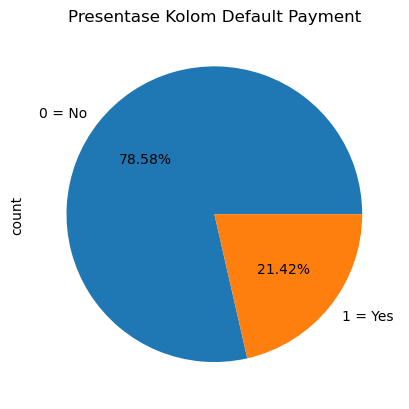

In [9]:
# Membuat piechart untuk melihat data pada kolom default_payment
fig,ax1 = plt.subplots()
df['default_payment_next_month'].value_counts().plot(kind='pie', autopct='%.2f%%', labels=['0 = No', '1 = Yes'], ax=ax1)

plt.title("Presentase Kolom Default Payment")

plt.show()

Dari data diatas dapat terlihat bahwa orang dengan default_payment = 0 adalah orang-orang yang bisa melunasi kredit dengan jumlah presentase total 78.58%. Sedangkan, default_payment = 1 adalah orang yang gagal untuk melunasi kredit dengan total presentase 21.42%. Bisa ditarik kesimpulan bahwa lebih banyak orang yang bisa melunasi kreditnya.

### Melihat hubungan default payment dan gender.

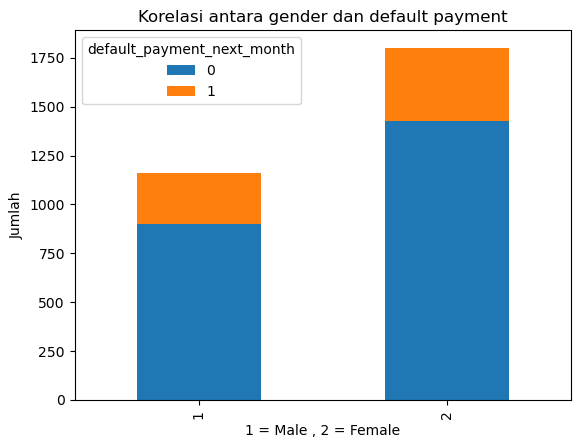

In [10]:
# Grouping berdasarkan gender
correlation_gender = df.groupby(['sex', 'default_payment_next_month']).size().unstack()

# Membuat bar chart
correlation_gender.plot(kind='bar', stacked=True)

plt.xlabel('1 = Male , 2 = Female')
plt.ylabel('Jumlah')
plt.title('Korelasi antara gender dan default payment')

plt.show()

Dari hasil visualisasi diatas terlihat bahwa jumlah pria yang mengalami kegagalan dalam melunasi kredit lebih sedikit dibandingkan perempuan.

### Melihat banyaknya Default Payment berdasarkan Education

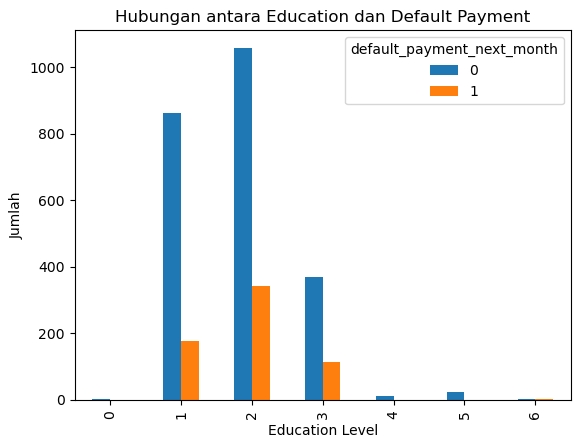

In [11]:
# Group by 'education_level' and count the occurrences of each category in 'default_payment_next_month'
correlation_data = df.groupby(['education_level', 'default_payment_next_month']).size().unstack()

# Plotting the bar chart
correlation_data.plot(kind='bar')

# Adding labels and title
plt.xlabel('Education Level')
plt.ylabel('Jumlah')
plt.title('Hubungan antara Education dan Default Payment')

# Display the plot
plt.show()

Dengan data Education (1:Graduate School, 2:University, 3:High School, 4:Others, 5,6:Unknown) terlihat bahwa tingkat edukasi University merupakan tingkat edukasi yang paling banyak gagal membayar kredit.

## 6. Feature Engineering

### Melakukan pencarian korelasi

In [12]:
# membuat variabel baru untuk kolom kategori dan numeric untuk mencari korelasi
cat = df[['sex','education_level','marital_status','pay_0','pay_2','pay_3','pay_4','pay_5','pay_6','default_payment_next_month']]
num = df[['limit_balance','age','bill_amt_1','bill_amt_2','bill_amt_3','bill_amt_4','bill_amt_5','bill_amt_6','pay_amt_1','pay_amt_2','pay_amt_3','pay_amt_4','pay_amt_5','pay_amt_6','default_payment_next_month']]

num

,limit_balance,age,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
0,80000.0,54.0,61454.0,61808.0,62290.0,29296.0,26210.0,17643.0,2545.0,2208.0,1336.0,2232.0,542.0,348.0,1
1,200000.0,49.0,49221.0,49599.0,50942.0,50146.0,50235.0,48984.0,1689.0,2164.0,2500.0,3480.0,2500.0,3000.0,0
2,20000.0,22.0,19568.0,19420.0,15535.0,1434.0,500.0,0.0,4641.0,1019.0,900.0,0.0,1500.0,0.0,1
3,260000.0,33.0,18457.0,22815.0,27086.0,27821.0,30767.0,29890.0,5000.0,5000.0,1137.0,5000.0,1085.0,5000.0,0
4,150000.0,32.0,159919.0,68686.0,161192.0,150464.0,143375.0,146411.0,4019.0,146896.0,157436.0,4600.0,4709.0,5600.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2960,80000.0,28.0,4280.0,2800.0,0.0,0.0,0.0,0.0,2800.0,0.0,0.0,0.0,0.0,0.0,0
2961,50000.0,51.0,752.0,300.0,5880.0,0.0,0.0,0.0,300.0,5880.0,0.0,0.0,0.0,0.0,1
2962,450000.0,38.0,390.0,390.0,390.0,390.0,390.0,390.0,390.0,780.0,390.0,390.0,390.0,390.0,1
2963,50000.0,44.0,1473.0,390.0,390.0,390.0,390.0,0.0,390.0,390.0,390.0,390.0,0.0,780.0,0


<Axes: >

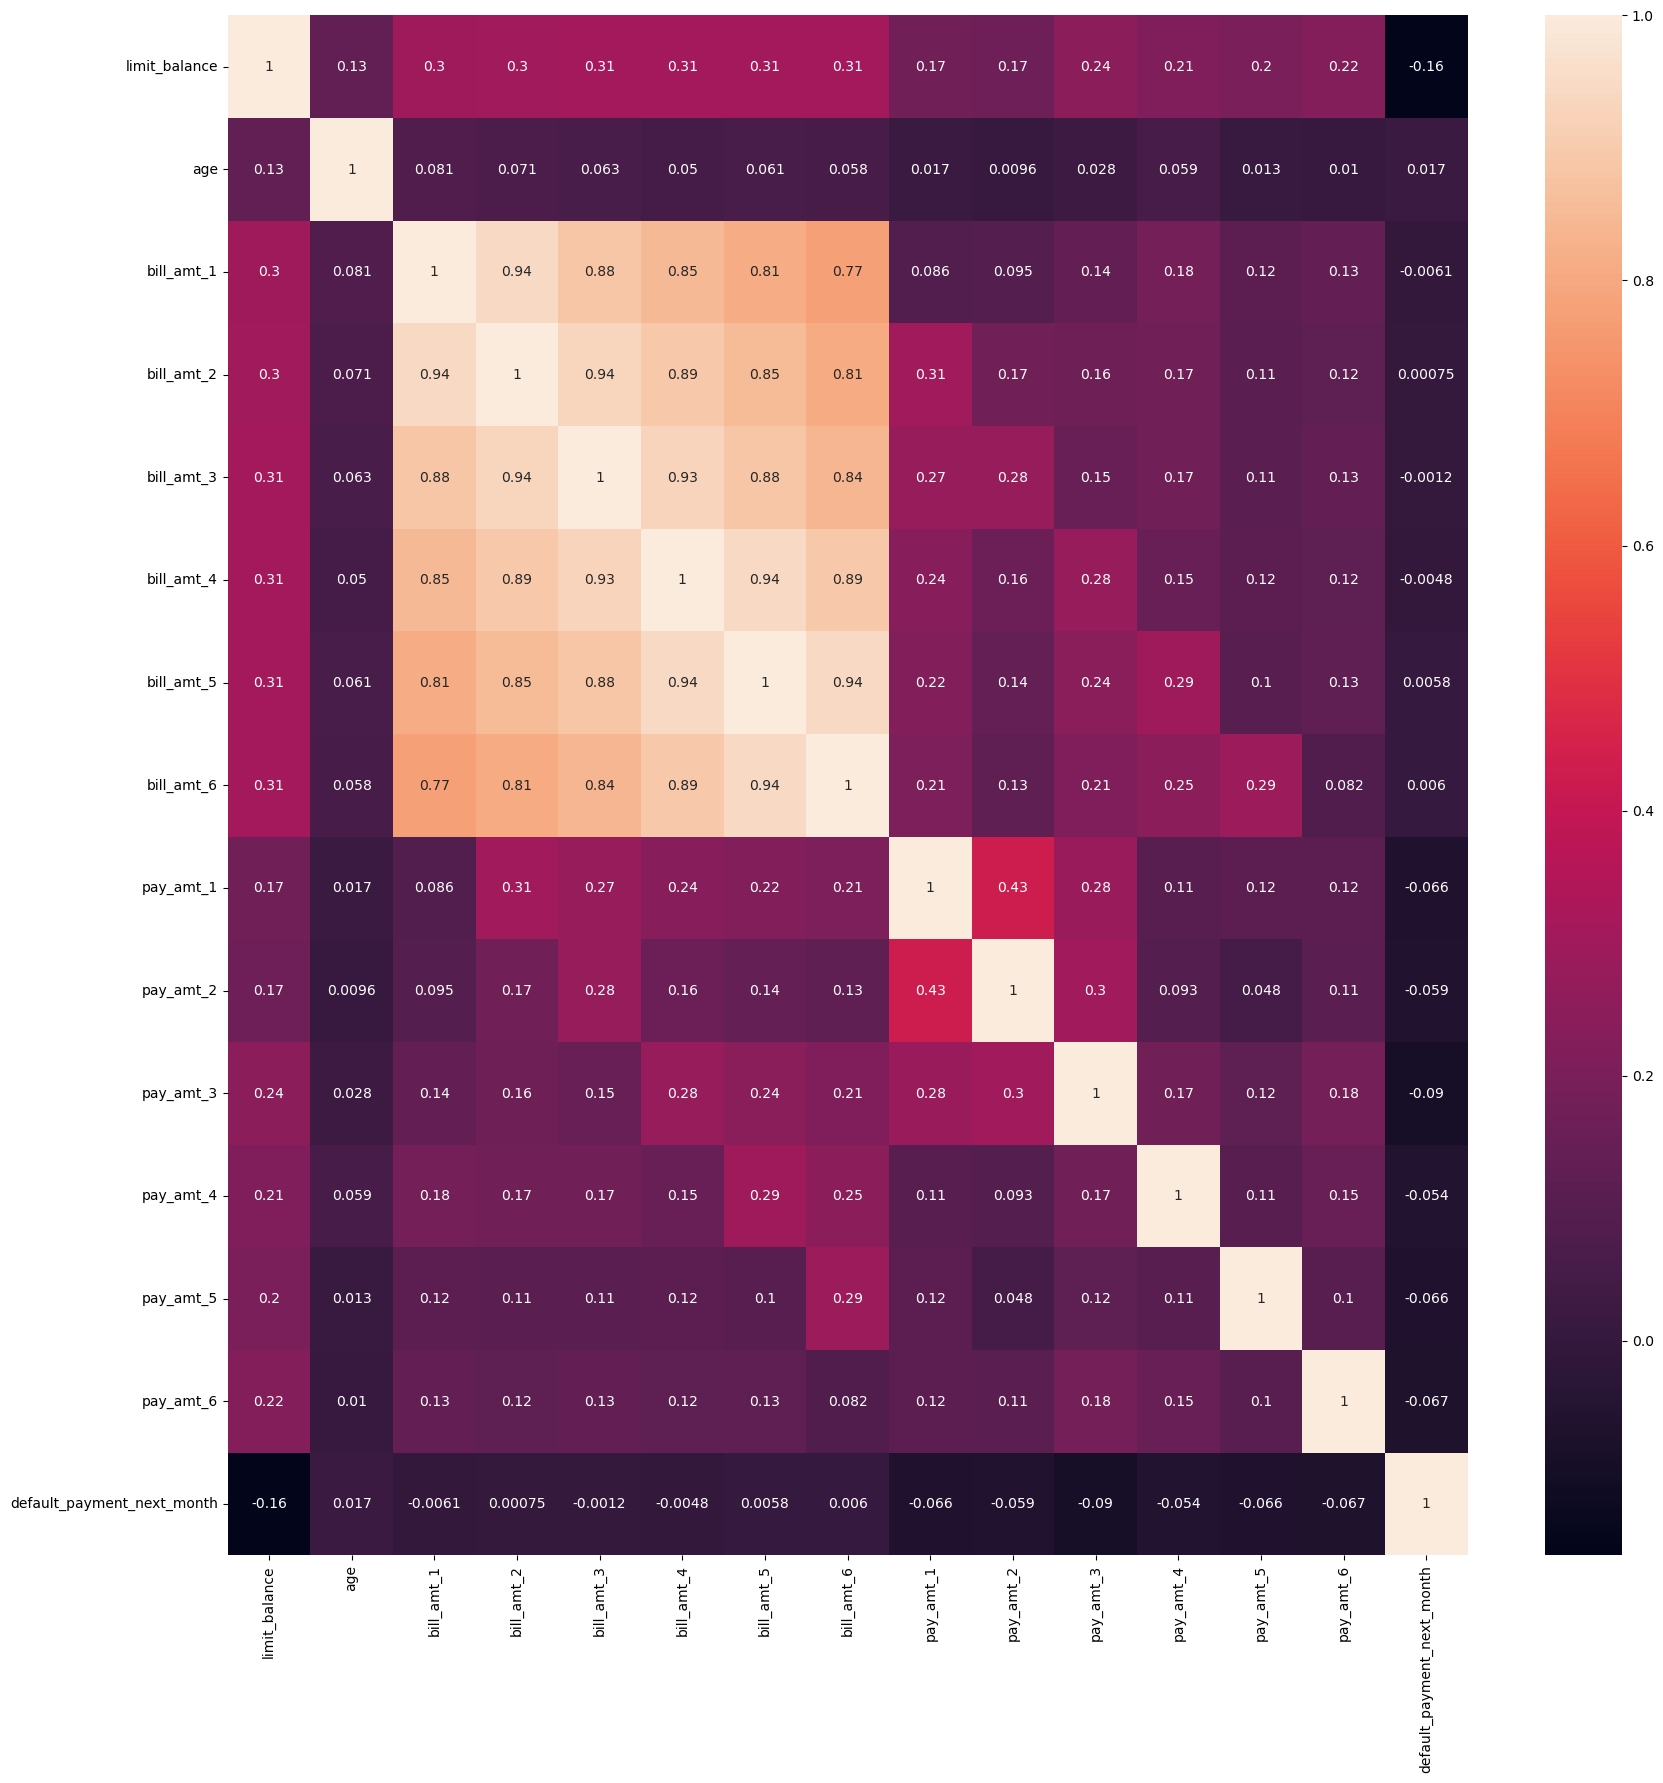

In [13]:
# membuat heatmap dan mencari korelasi numeric menggunakan pearson
plt.figure(figsize=(20,20))
sns.heatmap(num.corr(method='pearson'),annot=True)

Dari hasil heatmap diatas terlihat bahwa hanya kolom limit_balance yang memiliki nilai korelasi mendekati default_payment_next_month walaupun korelasinya rendah.

In [14]:
# mencari korelasi menggunakan kendalltau
for i in cat.columns :
    corr_tau, pval_k = stats.kendalltau(cat[i],cat['default_payment_next_month'])
    print(f"tau-correlation {i}: {corr_tau}, p-value: {pval_k}")

tau-correlation sex: -0.02162642304931005, p-value: 0.23911540032389955
tau-correlation education_level: 0.05755560529491701, p-value: 0.0009589626768338401
tau-correlation marital_status: -0.026438537470640195, p-value: 0.14754563955548056
tau-correlation pay_0: 0.3008024729505573, p-value: 6.040035145851998e-71
tau-correlation pay_2: 0.22901841464845465, p-value: 7.265130487967078e-41
tau-correlation pay_3: 0.21178014298597372, p-value: 3.797869325087989e-35
tau-correlation pay_4: 0.1966271069329996, p-value: 2.1622221709945718e-30
tau-correlation pay_5: 0.19716557575400478, p-value: 1.87970738409113e-30
tau-correlation pay_6: 0.1811016782475049, p-value: 4.38465378915166e-26
tau-correlation default_payment_next_month: 1.0, p-value: 0.0


Berdasarkan hasil perhitungan tau-correlation, kolom-kolom yang memiliki korelasi signifikan dengan kolom default_payment_next_month dengan p-value kurang dari 0.05 adalah: education_level, pay_0, pay_2, pay_3, pay_4, pay_5, pay_6.

In [15]:
# Membuat variabel baru yang berisi kolom-kolom yang akan digunakan untuk membuat model
df2 = df[['limit_balance','education_level', 'pay_0','pay_2','pay_3','pay_4','pay_5','pay_6','default_payment_next_month']]
df2

,limit_balance,education_level,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,default_payment_next_month
0,80000.0,6,0.0,0.0,0.0,0.0,0.0,0.0,1
1,200000.0,4,0.0,0.0,0.0,0.0,0.0,0.0,0
2,20000.0,6,0.0,0.0,0.0,0.0,0.0,0.0,1
3,260000.0,4,0.0,0.0,0.0,0.0,0.0,0.0,0
4,150000.0,4,0.0,0.0,0.0,-1.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...
2960,80000.0,3,-1.0,-1.0,-1.0,-2.0,-2.0,-2.0,0
2961,50000.0,3,-1.0,-1.0,-1.0,-1.0,-2.0,-2.0,1
2962,450000.0,2,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,1
2963,50000.0,2,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,0


Dapat terlihat bahwa kita sudah mendapatkan kolom-kolom yang akan kita gunakan untuk membuat model.

### Split antara X dan y

In [16]:
#Splitting antara 'X' dan 'y'
X = df2.drop(['default_payment_next_month'], axis=1)
y = df2['default_payment_next_month']

# Meload data
X

,limit_balance,education_level,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6
0,80000.0,6,0.0,0.0,0.0,0.0,0.0,0.0
1,200000.0,4,0.0,0.0,0.0,0.0,0.0,0.0
2,20000.0,6,0.0,0.0,0.0,0.0,0.0,0.0
3,260000.0,4,0.0,0.0,0.0,0.0,0.0,0.0
4,150000.0,4,0.0,0.0,0.0,-1.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2960,80000.0,3,-1.0,-1.0,-1.0,-2.0,-2.0,-2.0
2961,50000.0,3,-1.0,-1.0,-1.0,-1.0,-2.0,-2.0
2962,450000.0,2,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
2963,50000.0,2,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0


In [17]:
# Meload data y
y

0       1
1       0
2       1
3       0
4       0
       ..
2960    0
2961    1
2962    1
2963    0
2964    0
Name: default_payment_next_month, Length: 2964, dtype: int64

In [18]:
# Splitting antara train dan test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 20, stratify=y)
print('Train Size: ', X_train.shape)
print('Test Size: ', X_test.shape)

Train Size:  (2371, 8)
Test Size:  (593, 8)


### VIF

In [19]:
# Membuat fungsi untuk melakukan pengecekan VIF
def calc_vif(X):
    vif = pd.DataFrame()
    vif["variabel"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
    return(vif)

In [20]:
# Melakukan cek VIF pada X
calc_vif(X)

,variabel,VIF
0,limit_balance,2.076640
1,education_level,1.940776
2,pay_0,1.867808
3,pay_2,3.134799
4,pay_3,3.410222
5,pay_4,4.081393
6,pay_5,4.811420
7,pay_6,3.221104


Dari hasil pengecekan diatas, tidak terdapat kolom yang memiliki nilai VIF lebih dari 5 yang berarti idak terdapat multikolinearitas yang signifikan di antara kolom tersebut.

In [21]:
# Mencari nilai unique pada kolom
col_uniq = ['education_level', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'limit_balance']

for column in col_uniq:
    unique_values_count = df2[column].nunique()
    print(f"Jumlah unique value pada {column}: {unique_values_count}")

Jumlah unique value pada education_level: 7
Jumlah unique value pada pay_0: 11
Jumlah unique value pada pay_2: 10
Jumlah unique value pada pay_3: 9
Jumlah unique value pada pay_4: 10
Jumlah unique value pada pay_5: 9
Jumlah unique value pada pay_6: 8
Jumlah unique value pada limit_balance: 59


Dapat terlihat bahwa tidak terdapat kolom yang memiliki High Cardinality.

### Handling Outlier

Akan dilakukan handling outlier terhadap kolom yang numerical, yaitu kolom 'limit_balance'.

In [22]:
# Melakukan cek skewness
X_train['limit_balance'].skew()

1.009353960730358

Dari hasil pengecekan skew diatas, terlihat bahwa nilai skewnya adalah 1.009 yang berarti persebaran datanya agak condong ke kanan. Untuk mencari apakah terdapat outlier akan dilakukan pengecekan menggunakan boxplot.

<Axes: >

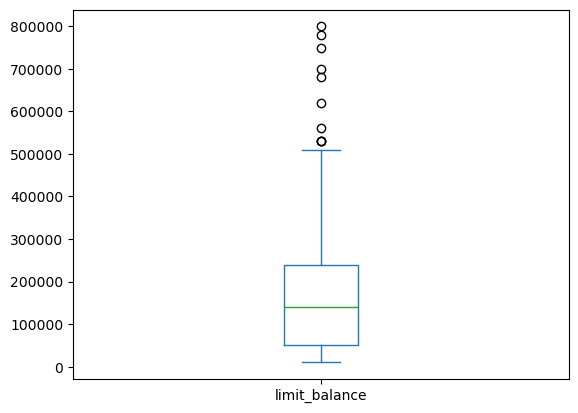

In [23]:
# Membuat boxplot
X_train['limit_balance'].plot(kind='box')

Dari hasil visualisasi, terlihat bahwa terdapat outlier pada kolom 'limit_balance'.

In [24]:
# melakukan capping menggunakan winsorizer
winsorizer = Winsorizer(capping_method='iqr', tail='both', fold=1.5, variables=['limit_balance'])
winsorizer.fit(X_train)
X_train = winsorizer.transform(X_train)

<Axes: >

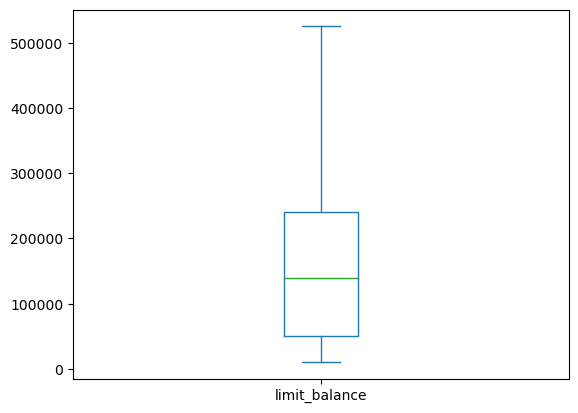

In [25]:
# Menampilkan boxplot
X_train['limit_balance'].plot(kind='box')

Terlihat dari boxplot bahwa sudah tidak terdapat outlier.

In [26]:
# Membuat columntransformer untuk pembuatan pipeline
num_columns = ['limit_balance']                                   

preprocessor = ColumnTransformer([('numeric', StandardScaler(), num_columns)], remainder='passthrough')      

Dikarenakan sudah dilakukan handling outlier pada kolom numerik maka akan menggunakan standardscaler, untuk data kategorikal dikarenakan sudah berbentuk encoding maka tidak akan dilakukan encoding lagi.

## 7. Model Definition

### Logistic Regression

In [27]:
# Membuat pipeline untuk Logistic Regression
logreg_pipeline = make_pipeline(preprocessor, LogisticRegression(random_state=42))

print('Pipeline steps : ', logreg_pipeline.steps)

Pipeline steps :  [('columntransformer', ColumnTransformer(remainder='passthrough',
                  transformers=[('numeric', StandardScaler(),
                                 ['limit_balance'])])), ('logisticregression', LogisticRegression(random_state=42))]


### SVM

In [28]:
# Membuat pipeline untuk SVM
svm_pipeline = make_pipeline(preprocessor, SVC(random_state=42))

print('Pipeline steps : ', svm_pipeline.steps)

Pipeline steps :  [('columntransformer', ColumnTransformer(remainder='passthrough',
                  transformers=[('numeric', StandardScaler(),
                                 ['limit_balance'])])), ('svc', SVC(random_state=42))]


### KNN

In [29]:
# Membuat pipeline untuk KNN
knn_pipeline = make_pipeline(preprocessor, KNeighborsClassifier())

print('Pipeline steps : ', knn_pipeline.steps)

Pipeline steps :  [('columntransformer', ColumnTransformer(remainder='passthrough',
                  transformers=[('numeric', StandardScaler(),
                                 ['limit_balance'])])), ('kneighborsclassifier', KNeighborsClassifier())]


## 8. Model Training

### Logistic Regression Training

In [30]:
# Melakukan training
logreg_pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric', StandardScaler(),
                                                  ['limit_balance'])])),
                ('logisticregression', LogisticRegression(random_state=42))])

### SVM Training

In [31]:
# Melakukan training
svm_pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric', StandardScaler(),
                                                  ['limit_balance'])])),
                ('svc', SVC(random_state=42))])

### KNN Training

In [32]:
knn_pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric', StandardScaler(),
                                                  ['limit_balance'])])),
                ('kneighborsclassifier', KNeighborsClassifier())])

## 9. Model Evaluation

Akan dilakukan evaluasi terhadap model yang sudah dibuat.

### Logistic Regression Predict & Evaluation

In [33]:
# Predict Train-set and Test-set
y_pred_train_logreg = logreg_pipeline.predict(X_train)
y_pred_test_logreg = logreg_pipeline.predict(X_test)

# Print classification report
print('Classification Report Logistic Regression Train: ')
print(classification_report(y_train, y_pred_train_logreg))
print('Classification Report Logistic Regression Test: ')
print(classification_report(y_test, y_pred_test_logreg))

Classification Report Logistic Regression Train: 
              precision    recall  f1-score   support

           0       0.84      0.98      0.90      1863
           1       0.79      0.33      0.46       508

    accuracy                           0.84      2371
   macro avg       0.81      0.65      0.68      2371
weighted avg       0.83      0.84      0.81      2371

Classification Report Logistic Regression Test: 
              precision    recall  f1-score   support

           0       0.83      0.95      0.89       466
           1       0.64      0.29      0.40       127

    accuracy                           0.81       593
   macro avg       0.73      0.62      0.64       593
weighted avg       0.79      0.81      0.78       593



Dari hasil diatas kita bisa melihat bahwa data train memiliki F1-Score 0.46 yang berarti model bisa memprediksi dengan benar hingga 46%. Sedangkan, data test memiliki nilai 0.40 yang berarti hanya bisa memprediksi dengan benar hingga 40%.

Dikarenakan F1-Score data train lebih besar dibandingkan data test, bisa dipastikan bahwa model overfit.

### SVM Predict & Evaluation

In [34]:
# Predict Train-set and Test-set
y_pred_train_svm = svm_pipeline.predict(X_train)
y_pred_test_svm = svm_pipeline.predict(X_test)

# Print classification report
print('Classification Report SVM Train: ')
print(classification_report(y_train, y_pred_train_svm))
print('Classification Report SVM Test: ')
print(classification_report(y_test, y_pred_test_svm))

Classification Report SVM Train: 
              precision    recall  f1-score   support

           0       0.86      0.96      0.91      1863
           1       0.77      0.44      0.56       508

    accuracy                           0.85      2371
   macro avg       0.82      0.70      0.74      2371
weighted avg       0.84      0.85      0.84      2371

Classification Report SVM Test: 
              precision    recall  f1-score   support

           0       0.84      0.94      0.89       466
           1       0.62      0.35      0.45       127

    accuracy                           0.81       593
   macro avg       0.73      0.65      0.67       593
weighted avg       0.79      0.81      0.79       593



Dari hasil diatas kita bisa melihat bahwa data train memiliki F1-Score 0.56 yang berarti model bisa memprediksi dengan benar hingga 56%. Sedangkan, data test memiliki nilai 0.45 yang berarti hanya bisa memprediksi dengan benar hingga 45%.

Dikarenakan F1-Score data train lebih besar dibandingkan data test, bisa dipastikan bahwa model overfit.

### KNN

In [35]:
# Predict Train-set and Test-set
y_pred_train_knn = knn_pipeline.predict(X_train)
y_pred_test_knn = knn_pipeline.predict(X_test)

# Print classification report
print('Classification Report KNN Train: ')
print(classification_report(y_train, y_pred_train_knn))
print('Classification Report KNN Test: ')
print(classification_report(y_test, y_pred_test_knn))

Classification Report KNN Train: 
              precision    recall  f1-score   support

           0       0.87      0.96      0.91      1863
           1       0.76      0.49      0.60       508

    accuracy                           0.86      2371
   macro avg       0.82      0.73      0.76      2371
weighted avg       0.85      0.86      0.85      2371

Classification Report KNN Test: 
              precision    recall  f1-score   support

           0       0.84      0.93      0.88       466
           1       0.58      0.36      0.45       127

    accuracy                           0.81       593
   macro avg       0.71      0.65      0.67       593
weighted avg       0.79      0.81      0.79       593



Dari hasil diatas kita bisa melihat bahwa data train memiliki F1-Score 0.60 yang berarti model bisa memprediksi dengan benar hingga 60%. Sedangkan, data test memiliki nilai 0.45 yang berarti hanya bisa memprediksi dengan benar hingga 45%.

Dikarenakan F1-Score data train lebih besar dibandingkan data test, bisa dipastikan bahwa model overfit.

Dari ketiga model diatas kita bisa mengambil kesimpulan bahwa mayoritas keseluruhan model mengalami overfit. Dikarenakan model KNN mendapatkan F1-Score paling tinggi yaitu 60, maka bisa dipastikan bahwa untuk kasus ini KNN merupakan model yang paling baik dibandingkan kedua model yang lain

### Cross Validation

Untuk melakukan cross validation akan digunakan F1 Score. F1 score menggabungkan precision dan recall. Alasan digunakan F1 Score adalah untuk memperhitungkan False Positive dan False Negative.

#### Logistic Regression Cross Validation

In [36]:
#Cross Validation Logistic Regression

logreg_f1_train_cross_val = cross_val_score(logreg_pipeline,
                                     X_train,
                                     y_train,
                                     cv=3,
                                     scoring="f1")

print('Logistic Regression F1 Score - All - Cross Validation  : ', logreg_f1_train_cross_val)
print('Logistic Regression F1 Score - Mean - Cross Validation : ', logreg_f1_train_cross_val.mean())
print('Logistic Regression F1 Score - Std - Cross Validation  : ', logreg_f1_train_cross_val.std())
print('Logistic Regression F1 Score - Range of Test-Set       : ', (logreg_f1_train_cross_val.mean()-logreg_f1_train_cross_val.std()) , '-', (logreg_f1_train_cross_val.mean()+logreg_f1_train_cross_val.std()))

Logistic Regression F1 Score - All - Cross Validation  :  [0.44621514 0.45021645 0.4556962 ]
Logistic Regression F1 Score - Mean - Cross Validation :  0.4507092640634423
Logistic Regression F1 Score - Std - Cross Validation  :  0.0038862825804106375
Logistic Regression F1 Score - Range of Test-Set       :  0.4468229814830317 - 0.45459554664385293


Hasil dari cross validation menggunakan F1-Score pada logistic regression adalah nilai F1 rata-rata: 0,4507, yang menunjukkan performance moderat, karena F1 score makin mendekati 1 semakin baik. Konsistensi standar deviasi sangat rendah (0,0038), menunjukkan bahwa kinerja model konsisten di seluruh fold dalam cross validation. Model tampaknya baik dalam mengidentifikasi true positive dan true negative

#### SVM Cross Validation

In [37]:
#Cross Validation SVM

svm_f1_train_cross_val = cross_val_score(svm_pipeline,
                                     X_train,
                                     y_train,
                                     cv=3,
                                     scoring="f1")

print('SVM F1 Score - All - Cross Validation  : ', svm_f1_train_cross_val)
print('SVM  Score - Mean - Cross Validation : ', svm_f1_train_cross_val.mean())
print('SVM  Score - Std - Cross Validation  : ', svm_f1_train_cross_val.std())
print('SVM  Score - Range of Test-Set       : ', (svm_f1_train_cross_val.mean()-svm_f1_train_cross_val.std()) , '-', (svm_f1_train_cross_val.mean()+svm_f1_train_cross_val.std()))

SVM F1 Score - All - Cross Validation  :  [0.47908745 0.51764706 0.5503876 ]
SVM  Score - Mean - Cross Validation :  0.515707369398079
SVM  Score - Std - Cross Validation  :  0.029140458074123396
SVM  Score - Range of Test-Set       :  0.48656691132395563 - 0.5448478274722024


Hasil dari cross validation menggunakan F1-Score pada svm adalah nilai F1 rata-rata: 0,5157, yang menunjukkan kinerja yang baik, karena F1 score hampir mendekati 1 dianggap sebagai kinerja yang baik. Standar deviasi relatif rendah 0,029, menunjukkan bahwa kinerja model konsisten di seluruh fold dalam cross validation. Model tampaknya baik dalam mengidentifikasi true positive dan true negative, dan memiliki kinerja yang relatif konsisten di seluruh fold. 

#### KNN Cross Validation

In [38]:
#Cross Validation KNN

knn_f1_train_cross_val = cross_val_score(knn_pipeline,
                                     X_train,
                                     y_train,
                                     cv=3,
                                     scoring="f1")

print('KNN F1 Score - All - Cross Validation  : ', knn_f1_train_cross_val)
print('KNN  Score - Mean - Cross Validation : ', knn_f1_train_cross_val.mean())
print('KNN  Score - Std - Cross Validation  : ', knn_f1_train_cross_val.std())
print('KNN  Score - Range of Test-Set       : ', (knn_f1_train_cross_val.mean()-knn_f1_train_cross_val.std()) , '-', (knn_f1_train_cross_val.mean()+knn_f1_train_cross_val.std()))

KNN F1 Score - All - Cross Validation  :  [0.4676259  0.48507463 0.53818182]
KNN  Score - Mean - Cross Validation :  0.4969607814426884
KNN  Score - Std - Cross Validation  :  0.03000549867353462
KNN  Score - Range of Test-Set       :  0.46695528276915377 - 0.526966280116223


Hasil dari cross validation menggunakan F1-Score pada knn adalah nilai F1 rata-rata: 0,4969, yang menunjukkan performance moderat, karena F1 score makin mendekati 1 semakin baik.  Standar deviasi relatif rendah (0,030), menunjukkan bahwa kinerja model konsisten di seluruh fold dalam cross validation. Model tampaknya baik dalam mengidentifikasi true positive dan true negative, dan memiliki kinerja yang relatif konsisten di seluruh fold.

Berdasarkan hasil cross validation yang telah dibahas sebelumnya, dapat disimpulkan bahwa model SVM secara keseluruhan merupakan model terbaik untuk mengklasifikasikan data. Nilai F1 rata-rata model SVM (0,5157) lebih tinggi daripada nilai F1 rata-rata model Regresi Logistik (0,4507) dan KNN (0,4969).

### Hyperparameter Tuning

In [40]:
# Melakukan tuning dengan grid search
grid_search_params = {
    'svc__kernel':['rbf'],
    'svc__degree':[1, 2, 3, 5, 9],
    'svc__C':[ 1, 10, 100],
    'svc__gamma':[0.1, 100, 'scale'],
    'svc__class_weight':['balanced'],
}

grid_svm = GridSearchCV(estimator=svm_pipeline, param_grid=grid_search_params, cv=3, n_jobs=-1, verbose=10, scoring='f1')
grid_svm.fit(X_train, y_train)

Fitting 3 folds for each of 45 candidates, totalling 135 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('numeric',
                                                                         StandardScaler(),
                                                                         ['limit_balance'])])),
                                       ('svc', SVC(random_state=42))]),
             n_jobs=-1,
             param_grid={'svc__C': [1, 10, 100],
                         'svc__class_weight': ['balanced'],
                         'svc__degree': [1, 2, 3, 5, 9],
                         'svc__gamma': [0.1, 100, 'scale'],
                         'svc__kernel': ['rbf']},
             scoring='f1', verbose=10)

In [41]:
# mencari parameter terbaik
grid_svm.best_params_

{'svc__C': 1,
 'svc__class_weight': 'balanced',
 'svc__degree': 1,
 'svc__gamma': 'scale',
 'svc__kernel': 'rbf'}

In [42]:
# membuat variabel untuk best parameter
best_svm = grid_svm.best_estimator_
best_svm

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric', StandardScaler(),
                                                  ['limit_balance'])])),
                ('svc',
                 SVC(C=1, class_weight='balanced', degree=1, random_state=42))])

In [44]:
# Predict Train-set and Test-set
y_pred_train_grid_svm = grid_svm.predict(X_train)
y_pred_test_grid_svm = grid_svm.predict(X_test)

# Print classification report
print('Classification Report SVM Train After Tuning: ')
print(classification_report(y_train, y_pred_train_grid_svm))
print('Classification Report SVM Test After Tuning: ')
print(classification_report(y_test, y_pred_test_grid_svm))

Classification Report SVM Train After Tuning: 
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      1863
           1       0.56      0.61      0.59       508

    accuracy                           0.82      2371
   macro avg       0.73      0.74      0.73      2371
weighted avg       0.82      0.82      0.82      2371

Classification Report SVM Test After Tuning: 
              precision    recall  f1-score   support

           0       0.88      0.85      0.86       466
           1       0.51      0.57      0.54       127

    accuracy                           0.79       593
   macro avg       0.69      0.71      0.70       593
weighted avg       0.80      0.79      0.79       593



Terlihat setelah dilakukan tuning, F1-Score meningkat dari yang tadinya pada train nilainya 0.56 sekarang 0.59 dan pada test yang tadinya 0.45 menjadi 0.54. Dari hasil ini kita bisa mengambil kesimpulan bahwa tuning yang kita lakukan berhasil meningkatkan score dan mengurangi overfit.

## 10. Model Saving

In [45]:
# Menyimpan model
with open('model.pkl', 'wb') as model:
  pickle.dump(best_svm, model)

## 11. Model Inference

Model terdapat pada inference.ipynb

## 12. Pengambilan Kesimpulan

Dari melakukan analisis dan pembuatan model diatas dapat diambil kesimpulan bahwa model yang terbaik adalah SVM. Dikarenakan hasil scorenya kurang memuaskan maka dilakukan hyperparameter tuning menggunakan Grid Search dengan parameter terbaik yang ditemukan adalah C=1, class weight = balanced, degree = 1, gamma = scale dan kernel = rbf.

Meskipun begitu model yang dibuat masih belum cukup baik karena hanya memiliki F1-Score train 0.59 dan test 0.54 masih jauh dari nilai terbaiknya yaitu 1.00. Mungkin nilainya yang masih kurang baik ini bisa ditingkatkan dengan menambah data pada dataset untuk bisa menghasilkan model yang lebih baik kedepannya. 

## Conceptual Problems

1. Apakah yang dimaksud dengan coeficient pada logistic regression?  
Coefficient adalah parameter yang digunakan untuk menghitung probabilitas suatu data masuk ke dalam kelas tertentu. Dalam hal ini perubahan variabel feature mempengaruhi target.


2. Apakah fungsi parameter kernel pada SVM? Jelaskan salah satu kernel yang kalian pahami!  
Parameter kernel digunakan untuk menentukan metode perhitungan jarak antara dua titik data. Penggunaan kernel yang berbeda akan menghasilkan fungsi jarak yang berbeda, sehingga memengaruhi performa model SVM. Salah satu jenis kernel, yaitu kernel RBF, mengukur jarak antara dua titik data dengan menggunakan fungsi radial basis function (RBF). Dalam kernel RBF, perhitungan jarak antara dua titik data dilakukan dengan mengalikan jarak Euclidean antara x dan y dengan fungsi eksponensial.

3. Bagaimana cara memilih K yang optimal pada KNN ?  
Proses memilih K yang optimal lebih bersifat eksperimental dan trial & error. Pendekatan yang umum digunakan melibatkan teknik tuning hyperparameter menggunakan metode Grid Search atau Random Search.

4. Apa yang dimaksud dengan metrics-metrics berikut : Accuracy, Precision, Recall, F1 Score, dan kapan waktu yang tepat untuk menggunakannya ?  

**Accuracy** = Mengukur seberapa banyak data yang diprediksi benar oleh model. Semakin tinggi nilai accuracy akan semakin bagus. Cocok digunakan ketika dataset memiliki distribusi data yang balance.

**Precision** = Mengukur berapa banyak prediksi positive yang memang true positive. Digunakan ketika ingin meminimalisir False Positive.

**Recall** = Mengukur seberapa banyak data yang diprediksi true positive dari keseluruhan data yang true positive. Berguna untuk meminimalkan jumlah false negative.

**F1 Score** = Merupakan harmonic mean dari precision dan recall. Berguna jika ingin mencapai balance antara precision dan recall.